# Physical Interpretation of HyMoLAP Parameters - CAMELS-FR

**Objective:** Identify catchment controls on HyMoLAP calibrated parameters

**Parameters:** μ (nonlinearity), λ , Qs (discharge scaling [m^3/s]), qs (rainfall scaling [mm/day])

**Dataset:** CAMELS-FR, 549 catchments

**Author:** Lionel Cedric Gohouede

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import AgglomerativeClustering

plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 9
import warnings
warnings.filterwarnings('ignore')

print("✓ Libraries loaded")

✓ Libraries loaded


## 1. Data Loading

In [ ]:
from google.colab import drive
from pathlib import Path
import pandas as pd

drive.mount("/content/drive")
DATA_DIR = Path("/content/drive/MyDrive/Colab Notebooks/Data")

params = pd.read_csv(DATA_DIR / 'dHyMoLAP_Simulation_Data_CAMELS_FR.csv')
climate = pd.read_csv(DATA_DIR / 'CAMELS_FR_climatic_statistics.csv', sep=';')
hydro = pd.read_csv(DATA_DIR / 'CAMELS_FR_hydrological_signatures.csv', sep=';')
hydro_yearly = pd.read_csv(DATA_DIR / 'CAMELS_FR_hydroclimatic_statistics_joint_availability_yearly.csv', sep=';')
topo = pd.read_csv(DATA_DIR / 'CAMELS_FR_topography_general_attributes.csv', sep=';')
soil = pd.read_csv(DATA_DIR / 'CAMELS_FR_soil_general_attributes.csv', sep=';')
geology = pd.read_csv(DATA_DIR / 'CAMELS_FR_geology_attributes.csv', sep=';')
hydrogeology = pd.read_csv(DATA_DIR / 'CAMELS_FR_hydrogeology_attributes.csv', sep=';')
landcover = pd.read_csv(DATA_DIR / 'CAMELS_FR_land_cover_attributes.csv', sep=';')

Parameters: 549 catchments
CAMELS-FR: 654 catchments total


In [ ]:
# Standardize station ID columns
for df in [climate, hydro, hydro_yearly, topo, soil, geology, hydrogeology, landcover]:
    if 'sta_code_h3' in df.columns:
        df.rename(columns={'sta_code_h3': 'station_id'}, inplace=True)

# Merge all attributes
catchment_attrs = topo.copy()
for df in [climate, hydro, hydro_yearly, soil, geology, hydrogeology, landcover]:
    catchment_attrs = catchment_attrs.merge(df, on='station_id', how='outer')

# INNER JOIN with parameters (only calibrated catchments)
data = params.merge(catchment_attrs, on='station_id', how='inner')

print(f"Final dataset: {len(data)} catchments with both parameters and attributes")

Final dataset: 4941 catchments with both parameters and attributes


## 2. Physical Constraints and Data Quality

**Physical constraint:** Qs and qs cannot be negative or zero (division by zero). Minimum value = 1e-6 mm/day.

In [ ]:
# Apply physical constraints
EPSILON = 1e-6
params_to_analyze = ['MU', 'LAMBDA', 'Qs', 'qs']

print("Applying physical constraints (Qs, qs ≥ 1e-6):")
for param in ['Qs', 'qs']:
    n_zero = (data[param] == 0).sum()
    n_neg = (data[param] < 0).sum()
    print(f"  {param}: {n_zero} zeros, {n_neg} negative values → Clipping to {EPSILON}")
    data[param] = data[param].clip(lower=EPSILON)

# Quality statistics
print("\nParameter Statistics:")
quality_stats = []
for param in params_to_analyze:
    Q1, Q3 = data[param].quantile([0.25, 0.75])
    IQR = Q3 - Q1
    n_outliers = (data[param] > Q3 + 3*IQR).sum()

    quality_stats.append({
        'Parameter': param,
        'Mean': data[param].mean(),
        'Std': data[param].std(),
        'Median': data[param].median(),
        'Min': data[param].min(),
        'Max': data[param].max(),
        'Outliers_IQR': n_outliers
    })

quality_df = pd.DataFrame(quality_stats)
display(quality_df)
quality_df.to_csv('Stats_01_Parameter_Quality.csv', index=False)
print("\n✓ Saved: Stats_01_Parameter_Quality.csv")

Applying physical constraints (Qs, qs ≥ 1e-6):
  Qs: 1908 zeros, 0 negative values → Clipping to 1e-06
  qs: 1134 zeros, 0 negative values → Clipping to 1e-06

Parameter Statistics:


,Parameter,Mean,Std,Median,Min,Max,Outliers_IQR
0,MU,1.140199,0.126740,1.107,0.815000,2.006,27
1,LAMBDA,34.214246,18.344864,31.304,0.906000,171.016,81
2,Qs,17.586128,166.687197,0.024,0.000001,3031.126,576
3,qs,4.334485,30.613466,0.151,0.000001,453.180,324



✓ Saved: Stats_01_Parameter_Quality.csv


## 4. Inter-Parameter Correlations

**Figure note for paper:** Scatter plots (lower triangle) with Spearman ρ. Correlation matrix (upper triangle) shows parameter relationships.

In [ ]:
# Compute correlation matrices
param_corr = data[params_to_analyze].corr(method='spearman')

print("Inter-Parameter Correlations (Spearman):")
display(param_corr)
param_corr.to_csv('Stats_02_InterParameter_Correlations.csv')
print("✓ Saved: Stats_02_InterParameter_Correlations.csv")

Inter-Parameter Correlations (Spearman):


,MU,LAMBDA,Qs,qs
MU,1.000000,0.162650,0.827811,0.867185
LAMBDA,0.162650,1.000000,-0.006982,-0.057572
Qs,0.827811,-0.006982,1.000000,0.936076
qs,0.867185,-0.057572,0.936076,1.000000


✓ Saved: Stats_02_InterParameter_Correlations.csv


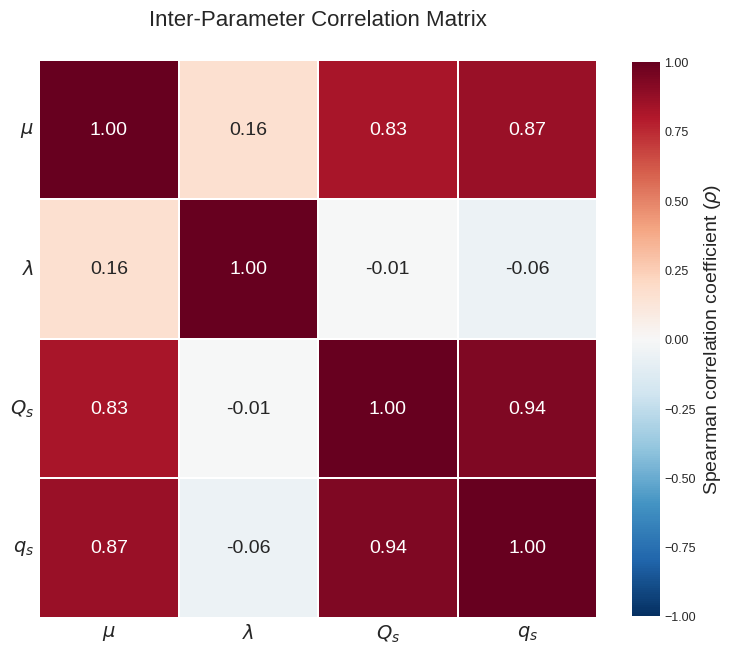

✓ Full correlation matrix saved to: Full_Correlation_Matrix.pdf


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1. Define the mathematical mapping (Case-Sensitive)
tex_map = {
    'mu': r'$\mu$',
    'lambda': r'$\lambda$',
    'Qs': r'$Q_s$',
    'qs': r'$q_s$'
}

# 2. Compute the Spearman correlation matrix
param_corr = data[params_to_analyze].corr(method='spearman')

# 3. Setup the labels for the plot using the tex_map
plot_labels = ['$\mu$', '$\lambda$', '$Q_s$', '$q_s$' ]

# 4. Initialize the matplotlib figure
fig, ax = plt.subplots(figsize=(9, 8))

# 5. Draw the FULL heatmap
# (Removing 'mask' fills the entire square)
sns.heatmap(
    param_corr,
    cmap='RdBu_r',       # Red-Blue diverging palette
    vmax=1, vmin=-1,     # Anchored at -1 and 1
    center=0,
    annot=True,          # Show the numerical Spearman rho values
    fmt=".2f",           # Round to 2 decimal places
    square=True,         # Ensures the heatmap cells are perfect squares
    linewidths=0.1,      # Adds clear borders between all cells
    #linecolor='black',   # Makes the grid lines distinct for publication
    cbar_kws={"shrink": .9, "label": r"Spearman correlation coefficient ($\rho$)"},
    annot_kws={"fontsize": 14}, # Adjust the number '12' to your desired size
    xticklabels=plot_labels,
    yticklabels=plot_labels
)

# 6. Formatting for professional appearance
plt.title('Inter-Parameter Correlation Matrix', fontsize=16, pad=25)
cbar = plt.gca().collections[0].colorbar
cbar.set_label(r"Spearman correlation coefficient ($\rho$)", fontsize=14) # Adjust the size as needed
plt.xticks(fontsize=14)
plt.yticks(fontsize=14, rotation=0)

# 7. Save the figure in high-resolution PDF format
plt.savefig('Full_Correlation_Matrix.pdf', bbox_inches='tight')
plt.show()

print("✓ Full correlation matrix saved to: Full_Correlation_Matrix.pdf")

In [ ]:
data[params_to_analyze]

,MU,LAMBDA,Qs,qs
0,1.085,32.807,0.000001,0.007
1,1.085,32.807,0.000001,0.007
2,1.085,32.807,0.000001,0.007
3,1.085,32.807,0.000001,0.007
4,1.085,32.807,0.000001,0.007
...,...,...,...,...
4936,1.123,1.530,296.187000,163.800
4937,1.123,1.530,296.187000,163.800
4938,1.123,1.530,296.187000,163.800
4939,1.123,1.530,296.187000,163.800


**Figure interpretation for paper:**
- Lower triangle: Scatter plots show raw relationships
- Upper triangle: Correlation matrix (color-coded by strength)
- Diagonal: Parameter distributions
- ρ = Spearman correlation coefficient; * p<0.05, ** p<0.01, *** p<0.001

## 5. Parameter-Attribute Correlations

**Strategy:** Test all hydrologically sensible attributes. Remove redundant variables (highly correlated, same physical meaning).

In [ ]:
# Define attribute name shortening for figures
ATTR_SHORT_NAMES = {
    'hyd_bfi_ladson': 'BFI_Ladson',
    'hyd_bfi_lfstat': 'BFI_lfstat',
    'hyd_bfi_pelletier_pet_ou': 'BFI_Pelletier',
    'hyd_slope_fdc': 'FDC_slope',
    'hyd_q_mean': 'Q_mean',
    'hyd_stream_elas': 'StreamElas',
    'hyd_q_freq_high': 'Q_freq_high',
    'hyd_q_freq_low': 'Q_freq_low',
    'cli_aridity_ou': 'Aridity_Oudin',
    'cli_aridity_pe': 'Aridity_Penman',
    'cli_aridity_pm': 'Aridity_PM',
    'cli_prec_mean': 'P_mean',
    'cli_pet_ou_mean': 'PET_Oudin',
    'cli_pet_pe_mean': 'PET_Penman',
    'cli_pet_pm_mean': 'PET_PM',
    'cli_prec_season_pet_ou': 'P_season',
    'cli_assync_ou': 'P-PET_async',
    'top_slo_mean': 'Slope',
    'top_altitude_mean': 'Altitude',
    'top_drainage_density': 'DrainDens',
    'top_mor_shape_factor': 'ShapeFactor',
    'top_mor_compact_coef': 'Compact',
    'top_mor_relief_ratio': 'ReliefRatio',
    'hgl_permeability': 'Permeability',
    'hgl_porosity': 'Porosity',
    'hgl_krs_karstic': 'Karst%',
    'sol_tawc': 'TAWC',
    'sol_depth_to_bedrock': 'Depth_bedrock',
    'sol_conductivity': 'Ksat',
    'hyc_jay_ratio_q_prec': 'Q/P_ratio',
    'hyc_jay_ratio_prec_pet_ou': 'P/PET_Oudin',
    'clc_2018_lvl1_1': 'Urban%',
    'clc_2018_lvl1_2': 'Agri%',
    'clc_2018_lvl1_3': 'Forest%',
    'geo_su': 'Geo_unconsol',
    'geo_sc': 'Geo_carbon',
    'geo_mt': 'Geo_metamorph'
}

# Get all numeric attributes (exclude non-sensical)
exclude_cols = ['station_id', 'MU', 'LAMBDA', 'Qs', 'qs', 'NSE_train', 'NSE_val',
                'RMSE_train', 'RMSE_val', 'geo_dom_class', 'clc_2018_lvl1_dom_class',
                'clc_2018_lvl2_dom_class', 'clc_2018_lvl3_dom_class', 'sol_stat', 'sol_agg_level',
                'cli_prec_date_max', 'hyd_q_date_max', 'hyd_q_date_qmna']

all_attrs = [col for col in data.columns if col not in exclude_cols and
             data[col].dtype in [np.float64, np.int64] and data[col].notna().sum() > len(data) * 0.5]

print(f"Total attributes available: {len(all_attrs)}")

Total attributes available: 127


In [ ]:
# Remove redundant variables (keep most correlated with parameters)
# Example: Multiple PET methods (Oudin, Penman, PM) - keep most relevant one per parameter

# Identify redundant groups
REDUNDANT_GROUPS = {
    'BFI': ['hyd_bfi_ladson', 'hyd_bfi_lfstat', 'hyd_bfi_pelletier_pet_ou'],
    'Aridity': ['cli_aridity_ou', 'cli_aridity_pe', 'cli_aridity_pm'],
    'PET': ['cli_pet_ou_mean', 'cli_pet_pe_mean', 'cli_pet_pm_mean'],
    'PET_yearly': ['hyc_jay_pet_ou', 'hyc_jay_pet_pe', 'hyc_jay_pet_pm'],
    'P/PET': ['hyc_jay_ratio_prec_pet_ou', 'hyc_jay_ratio_prec_pet_pe', 'hyc_jay_ratio_prec_pet_pm']
}

def select_best_from_group(param_name, attr_group):
    """Select attribute with highest correlation from redundant group"""
    available = [a for a in attr_group if a in all_attrs]
    if len(available) <= 1:
        return available

    # Compute correlations
    corrs = {}
    for attr in available:
        valid = data[[param_name, attr]].dropna()
        if len(valid) > 10:
            r, _ = stats.spearmanr(valid[param_name], valid[attr])
            corrs[attr] = abs(r)

    # Return best one
    if corrs:
        best = max(corrs, key=corrs.get)
        return [best]
    return available[:1]

# Build filtered attribute list per parameter
FILTERED_ATTRS = {}
for param in params_to_analyze:
    filtered = all_attrs.copy()

    # For each redundant group, keep only the best
    for group_name, group_attrs in REDUNDANT_GROUPS.items():
        best = select_best_from_group(param, group_attrs)
        # Remove others from list
        for attr in group_attrs:
            if attr not in best and attr in filtered:
                filtered.remove(attr)

    FILTERED_ATTRS[param] = filtered
    print(f"{param}: {len(filtered)} unique attributes (removed {len(all_attrs)-len(filtered)} redundant)")

MU: 117 unique attributes (removed 10 redundant)
LAMBDA: 117 unique attributes (removed 10 redundant)
Qs: 117 unique attributes (removed 10 redundant)
qs: 117 unique attributes (removed 10 redundant)


In [ ]:
# Compute correlations
def compute_correlations(param_name, attr_list):
    results = []
    for attr in attr_list:
        if attr in data.columns:
            valid = data[[param_name, attr]].dropna()
            if len(valid) > 10:
                r, pval = stats.spearmanr(valid[param_name], valid[attr])
                results.append({
                    'attribute': attr,
                    'short_name': ATTR_SHORT_NAMES.get(attr, attr[:20]),
                    'spearman_r': r,
                    'p_value': pval,
                    'n': len(valid),
                    'significant': pval < 0.05
                })

    df = pd.DataFrame(results)
    return df.sort_values('spearman_r', key=abs, ascending=False)

correlations = {}
for param in params_to_analyze:
    corr_results = compute_correlations(param, FILTERED_ATTRS[param])
    correlations[param] = corr_results

### Correlation Heatmaps (Top 15)

**Figure note for paper:** Vertical colorbar shows correlation strength. Shortened attribute names for clarity.

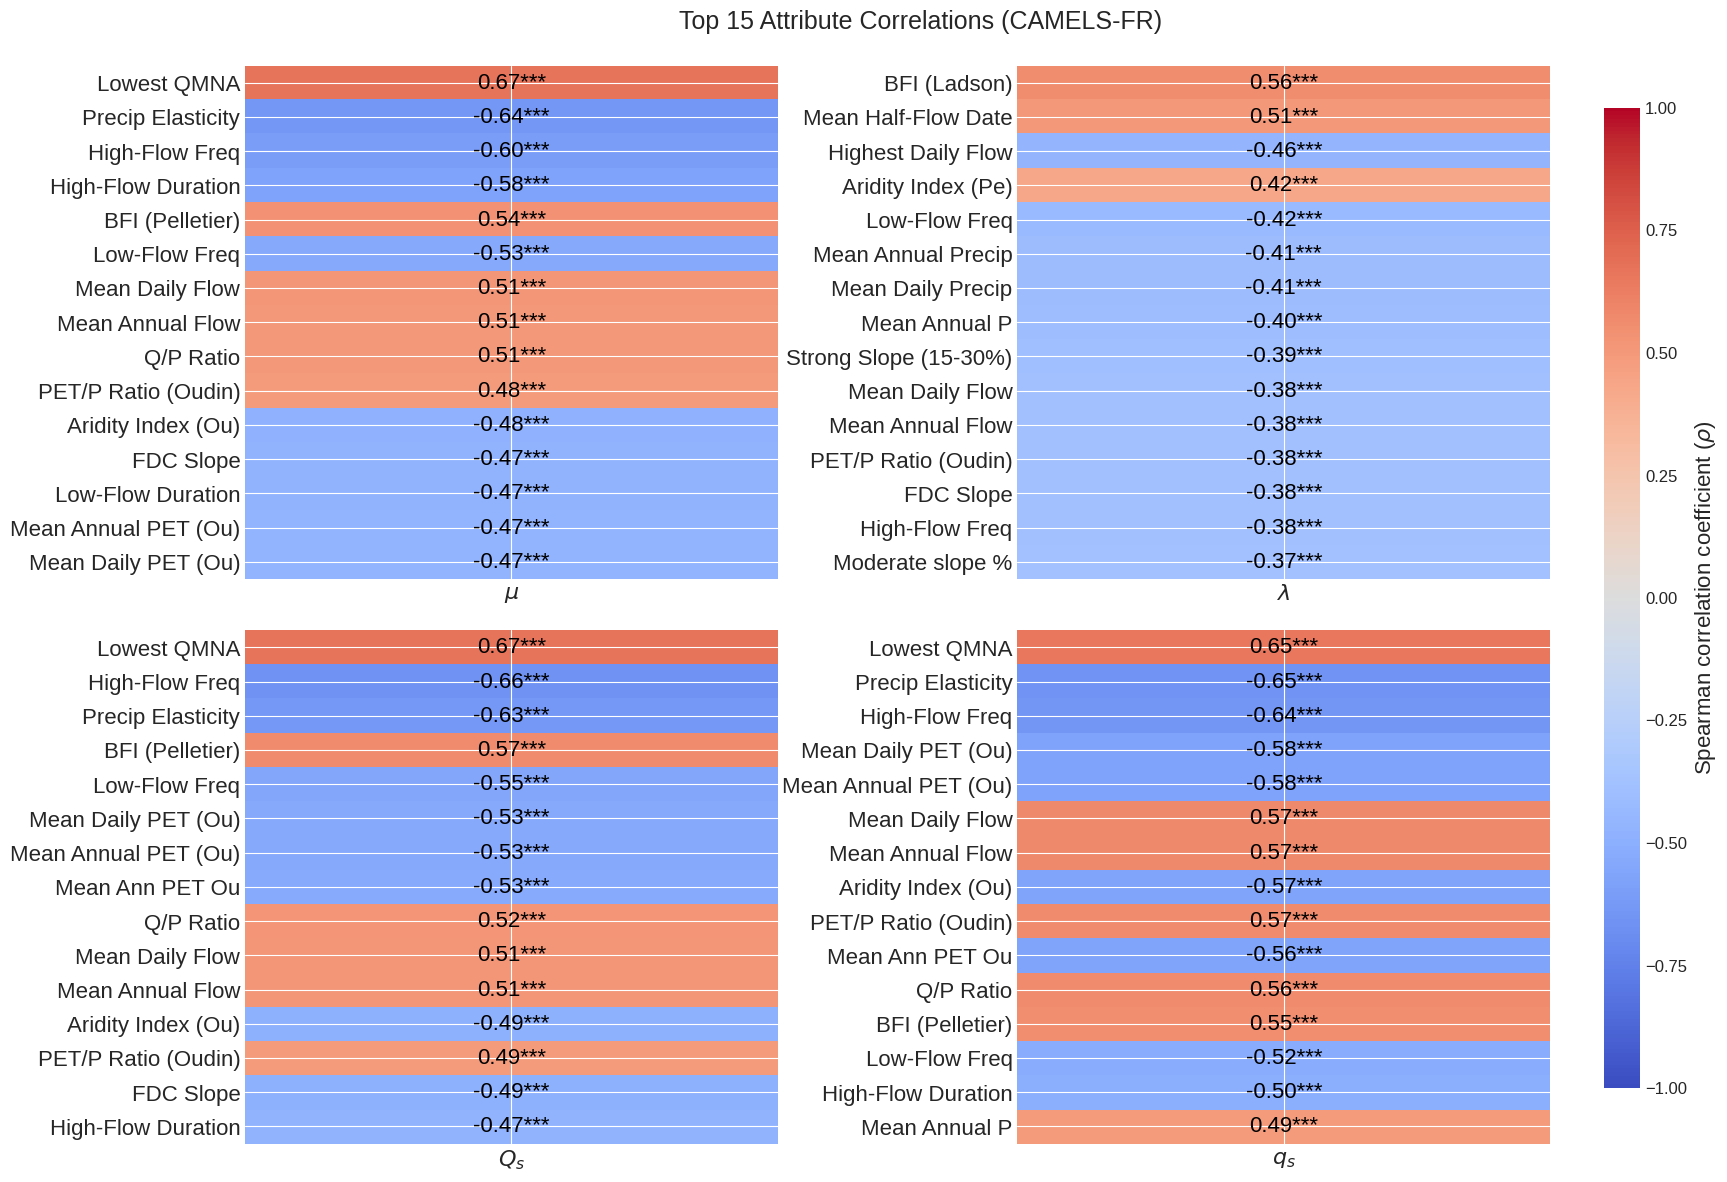

✓ Saved: Fig03_Correlations_Top15.pdf


In [ ]:
feature_name_mapping = {
    # ============================================================================
    # Flow characteristics - STRICTLY FROM CAMELS-FR DESCRIPTIONS
    # ============================================================================

    # Official: "lowest QMNA" (QMNA = monthly minimum annual flow)
    "hyd_q_qmna_min": "Lowest QMNA",               # 12 chars
        # Official: "mean annual precipitation (calculated on time steps when Q is not missing)"
    "hyc_jay_prec_mean": "Mean Annual P",    # 18 chars (Q-t = Q time steps)
    # Official: "mean annual PET using Oudin method (calculated on time steps when Q is not missing)"
    "hyc_jay_pet_ou": "Mean Ann PET Ou",      # 20 chars

    # Official: "mean annual PET using Penman-Monteith method (calculated on time steps when Q is not missing)"
    "hyc_jay_pet_pm": "Mean Ann PET PM",      # 20 chars

    # Official: "mean annual PET using Penman method (calculated on time steps when Q is not missing)"
    "hyc_jay_pet_pe": "Mean Ann PET Pe",      # 20 chars

    # Official: "precipitation elasticity of streamflow"
    "hyd_stream_elas": "Precip Elasticity",        # 18 chars

    # Official: "frequency of high-flow days (> 9 times the median daily flow)"
    "hyd_q_freq_high": "High-Flow Freq",           # 15 chars

    # Official: "average duration of high-flow events"
    "hyd_q_dur_high": "High-Flow Duration",        # 18 chars

    # Official: "frequency of low-flow days (< 0.2 times the mean daily flow)"
    "hyd_q_freq_low": "Low-Flow Freq",             # 14 chars

    # Official: "average duration of low-flow events"
    "hyd_q_dur_low": "Low-Flow Duration",          # 17 chars

    # Official: "mean daily streamflow"
    "hyd_q_mean": "Mean Daily Flow",               # 15 chars

    # Official: "mean annual streamflow"
    "hyd_q_mean_yr": "Mean Annual Flow",           # 16 chars

    # Official: "highest daily streamflow on record"
    "hyd_q_max": "Highest Daily Flow",             # 18 chars

    # Official: "slope of the flow duration curve (between 33rd and 66th streamflow percentiles)"
    "hyd_slope_fdc": "FDC Slope",                  # 10 chars

    # Official: "mean half-flow date (date on which the cumulative discharge since October first reaches half of the annual discharge)"
    "hyd_hfd_mean": "Mean Half-Flow Date",         # 19 chars

    # ============================================================================
    # Baseflow indices - STRICTLY FROM CAMELS-FR DESCRIPTIONS
    # ============================================================================

    # Official: "baseflow index using PET with Oudin method (Pelletier and Andréassian, 2020)"
    "hyd_bfi_pelletier_pet_ou": "BFI (Pelletier)",     # 16 chars

    # Official: "baseflow index (lfstat method)"
    "hyd_bfi_lfstat": "BFI (lfstat)",              # 13 chars

    # ============================================================================
    # Water balance - STRICTLY FROM CAMELS-FR DESCRIPTIONS
    # ============================================================================

    # Official: "ratio of mean daily Q to mean daily precipitation (calculated on time steps when Q is not missing)"
    "hyc_jay_ratio_q_prec": "Q/P Ratio",           # 10 chars

    # Official: "ratio of mean daily PET (Oudin method) to mean daily precipitation"
    "hyc_jay_ratio_prec_pet_ou": "PET/P Ratio (Oudin)", # 20 chars

    # ============================================================================
    # Precipitation - STRICTLY FROM CAMELS-FR DESCRIPTIONS
    # ============================================================================

    # Official: "mean daily precipitation"
    "cli_prec_mean": "Mean Daily Precip",          # 17 chars

    # Official: "mean annual long-term precipitation"
    "cli_prec_mean_yr": "Mean Annual Precip",      # 18 chars

    # Official: "average duration of dry periods (number of consecutive days < 1 mm day⁻¹)"
    "cli_prec_dur_low": "Dry Period Duration",     # 19 chars

    # ============================================================================
    # PET/Evapotranspiration - STRICTLY FROM CAMELS-FR DESCRIPTIONS
    # ============================================================================

    # Official: "mean daily PET (Oudin method)"
    "cli_pet_ou_mean": "Mean Daily PET (Ou)",      # 19 chars

    # Official: "mean annual long-term PET (Oudin method)"
    "cli_pet_ou_yr": "Mean Annual PET (Ou)",       # 20 chars

    # Official: "mean annual long-term PET (Penman-Monteith method...)"
    "cli_pet_pm_yr": "Mean Annual PET (PM)",       # 20 chars

    # Official: "mean annual long-term PET (Penman method...)"
    "cli_pet_pe_yr": "Mean Annual PET (Pe)",       # 20 chars

    # ============================================================================
    # Aridity - STRICTLY FROM CAMELS-FR DESCRIPTIONS
    # ============================================================================

    # Official: "aridity index - ratio of mean daily PET to mean daily precipitation"
    "cli_aridity_ou": "Aridity Index (Ou)",        # 18 chars

    # Official: "aridity index - ratio of mean daily PET to mean daily precipitation (using PET from Penman method)"
    "cli_aridity_pe": "Aridity Index (Pe)",        # 18 chars

    # Official: "aridity index - ratio of mean daily PET to mean daily precipitation (using PET from Penman-Monteith method)"
    "cli_aridity_pm": "Aridity Index (PM)",        # 18 chars

    # ============================================================================
    # Topography - STRICTLY FROM CAMELS-FR DESCRIPTIONS
    # ============================================================================

    # Official: "percentage of catchment area with slope between (15 - 30 %] - Strong slope"
    "top_slo_strong": "Strong Slope (15-30%)",     # 20 chars

    # ============================================================================
    # Shortened versions (as they appear in plots)
    # ============================================================================
    "StreamElas": "Precip Elasticity",
    "Q_freq_high": "High-Flow Freq",
    "BFI_Pelletier": "BFI (Pelletier)",
    "BFI_Ladson": "BFI (Ladson)",
    "top_slo_moderate" : "Moderate slope %",
    "Q_freq_low" : "Low-Flow Freq",
    "Q/P_ratio": "Q/P Ratio",
    "Q_mean": "Mean Daily Flow",
    "FDC_slope": "FDC Slope",
    "PET_Oudin": "Mean Daily PET (Ou)",
    "P/PET_Oudin": "PET/P Ratio (Oudin)",
    "Aridity_Oudin": "Aridity Index (Ou)",
    "BFI_lfstat": "BFI (lfstat)",
    "Aridity_Penman": "Aridity Index (Pe)",
    "P_mean": "Mean Daily Precip",
    "hyc_jay_ratio_prec_p": "PET/P Ratio (Oudin)",
}

import matplotlib.pyplot as plt

# ============================================================================
# Apply meaningful names mapping to correlations DataFrames
# ============================================================================

for param in params_to_analyze:
    correlations[param]['display_name'] = correlations[param]['short_name'].map(
        lambda x: feature_name_mapping.get(x, x)  # Use mapping if exists, otherwise keep original
    )

# ============================================================================
# Expert Mapping: Case-sensitive to respect Qs vs qs
# ============================================================================

tex_map = {
    'mu': r'$\mu$',
    'lambda': r'$\lambda$',
    'Qs': r'$Q_s$',   # Capital Q
    'qs': r'$q_s$',   # Small q
    'qc': r'$Q_c$',
    'MU': r'$\mu$',
    'LAMBDA': r'$\lambda$'
}

# ============================================================================
# Create figure with vertical colorbar on right
# ============================================================================

fig = plt.figure(figsize=(18, 14))
gs = fig.add_gridspec(2, 2, hspace=0.1, wspace=0.45, right=0.85)

for idx, param in enumerate(params_to_analyze):
    row, col = idx // 2, idx % 2
    ax = fig.add_subplot(gs[row, col])

    # Mapping logic: check exact match first, then lowercase if not found
    math_symbol = tex_map.get(param, tex_map.get(param.lower(), param))

    # Top 15 correlations logic
    top15 = correlations[param].head(15)
    corr_matrix = top15['spearman_r'].values.reshape(-1, 1)

    im = ax.imshow(corr_matrix, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)

    # Y-axis: meaningful attribute names (using display_name instead of short_name)
    ax.set_yticks(range(len(top15)))
    ax.set_yticklabels(top15['display_name'], fontsize=16)

    # X-axis: respecting case for Qs vs qs symbols
    ax.set_xticks([0])
    ax.set_xticklabels([math_symbol], fontsize=16)

    # Add correlation values + significance
    for i, (corr, pval) in enumerate(zip(top15['spearman_r'], top15['p_value'])):
        sig = "***" if pval < 0.001 else "**" if pval < 0.01 else "*" if pval < 0.05 else ""
        text_color = 'black'      # 'white' if abs(corr) > 0.5 else 'black'
        ax.text(0, i, f'{corr:.2f}{sig}', ha='center', va='center',
                color=text_color, fontsize=16)

# Colorbar setup
cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label(r'Spearman correlation coefficient ($\rho$)', fontsize=16)
cbar.ax.tick_params(labelsize=12)

plt.suptitle('Top 15 Attribute Correlations (CAMELS-FR)', fontsize=18, y=0.92)
plt.savefig('Fig03_Correlations_Top15.pdf', bbox_inches='tight')
plt.show()
print("✓ Saved: Fig03_Correlations_Top15.pdf")

**Figure interpretation for paper:**
- * p<0.05, ** p<0.01, *** p<0.001
- Red: negative correlation, Blue: positive correlation
- Shortened names used (see Stats CSVs for full attribute names)
- Redundant variables removed (e.g., only one PET method shown per parameter)